## Imports

In [1]:
# !pip install litstudy
# !pip install pyLDAvis
# !pip install trasnformers torch
# !pip install wordcloud

In [2]:
# Import other libraries
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sbs

# Options for plots
plt.rcParams['figure.figsize'] = (10, 6)
sbs.set('paper')

# Import litstudy
path = os.path.abspath(os.path.join('..'))
if path not in sys.path:
    sys.path.append(path)

import litstudy

In [3]:
from gensim import corpora
from gensim.models import LdaModel
import pyLDAvis
import pyLDAvis.gensim_models

import re
import nltk
from nltk.stem import WordNetLemmatizer
#from nltk.tokenize import regexp_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk import pos_tag
from nltk.corpus import wordnet, stopwords
# from gensim.utils import simple_preprocess
from collections import OrderedDict

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

from transformers import T5ForConditionalGeneration, T5Tokenizer

# nltk.download('stopwords')
# nltk.download('averaged_perceptron_tagger_eng')
# nltk.download('wordnet')

## Collecting the dataset

In [4]:
# Load files
docs_orig = litstudy.load_csv('papersPreprocessed.csv')

print('Total docs: ', len(docs_orig))
print('Total unique docs: ', docs_orig.unique)

Total docs:  901
Total unique docs:  <bound method DocumentSet.unique of <901 documents>>


## Lemmatization

In [5]:

# Limpeza do texto
def remove_tags_html(text):
    return re.sub(r'<.*?>', '', text)  # Remove tags

# Função para remover números
def remove_numbers(text):
    return re.sub(r'\d+', '', text)

# Função para mapear tags de POS do nltk para WordNet
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

# Lista de stopwords em inglês
stop_words = set(stopwords.words('english'))

# Inicializar o lematizador
lemmatizer = WordNetLemmatizer()

tokenizer = RegexpTokenizer(r'\w+')

# Função para lematizar um texto
def lemmatize_text(text):
    text = remove_tags_html(text)
    text = remove_numbers(text)
    tokens = tokenizer.tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]  # Remove stopwords 
    pos_tags = pos_tag(tokens)
    lemmatized_tokens = [lemmatizer.lemmatize(token, get_wordnet_pos(tag)) for token, tag in pos_tags]
    # Remover duplicatas preservando a ordem
    lemmatized_tokens = list(OrderedDict.fromkeys(lemmatized_tokens))
    return ' '.join(lemmatized_tokens)

# Modified loop to handle None values in abstracts
for doc in docs_orig:
    abstract = getattr(doc, 'abstract', None)
    if abstract is not None:
        abstract = abstract.lower()
    else:
        abstract = ''  # Set to empty string if None
    doc.abstract_lemmatize = lemmatize_text(abstract)

# print(docs_scp[0].abstract_lemmatize)
abstracts_lemmatize = [doc.abstract_lemmatize for doc in docs_orig]

In [6]:
print(abstracts_lemmatize[0])

machine learn ml novel method application asset pricing fit well within problem measurement economics unlike econometrics model design parameter estimation inference similar address may suit prediction apply decade success limit example abound literature recent year advance new efficient computation regularization nonlinearity improve sample article conduct comprehensive objective quantitative bibliometric analysis grow use web science wos data identify trend past geographical distribution authorship institutional contribution worldwide paper also dominant citation discuss computational algorithm expand econometric frontier top cite review highlight limitation provide conic view future practice


In [7]:
# Implementação do TF-IDF
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(abstracts_lemmatize)

# Converter a matriz TF-IDF em um DataFrame para melhor visualização (opcional)
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

print(tfidf_df.sum(axis=0).sort_values(ascending=False).head(30))

learn           24.232357
model           23.816704
portfolio       23.683518
use             22.723915
asset           21.646958
return          21.605044
market          21.498930
base            21.188645
risk            20.631623
propose         20.387690
result          20.256211
machine         19.651219
method          19.463264
stock           19.419371
data            19.357787
performance     18.832009
approach        18.464828
study           18.285935
paper           18.205698
optimization    17.722791
financial       17.500835
strategy        17.089928
high            16.185725
investment      16.032808
investor        16.008686
management      15.728384
price           15.536823
problem         15.413350
time            15.400161
algorithm       15.336196
dtype: float64


## Redução de Dimensionalidade com SVD

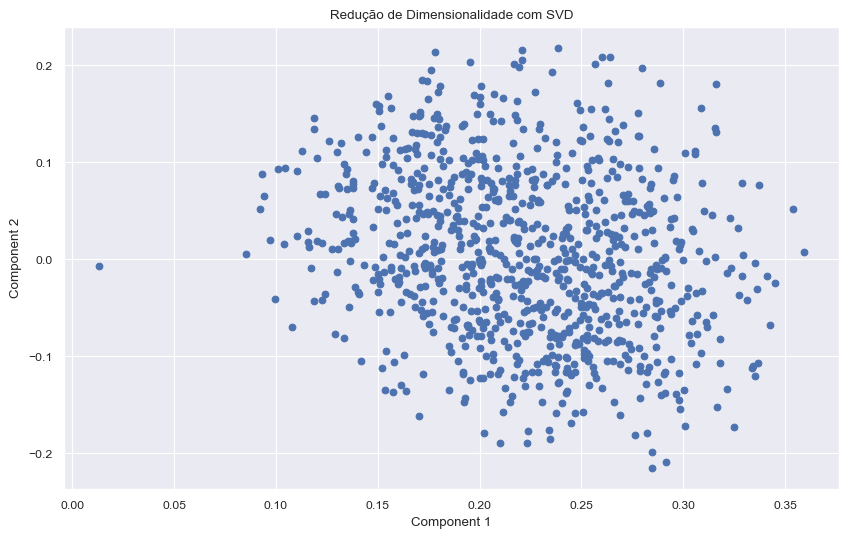

In [8]:
# Definir o número de componentes
n_components = 2  # Você pode ajustar esse valor conforme necessário

# Aplicar Truncated SVD
svd = TruncatedSVD(n_components=n_components)
reduced_matrix = svd.fit_transform(tfidf_matrix)

# Criar um DataFrame para a matriz reduzida
reduced_df = pd.DataFrame(reduced_matrix, columns=[f'Component {i+1}' for i in range(n_components)])

# Visualizar os dados reduzidos (opcional)
plt.scatter(reduced_df['Component 1'], reduced_df['Component 2'])
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('Redução de Dimensionalidade com SVD')
plt.show()


## Redução da Dimensionalidade com PCA

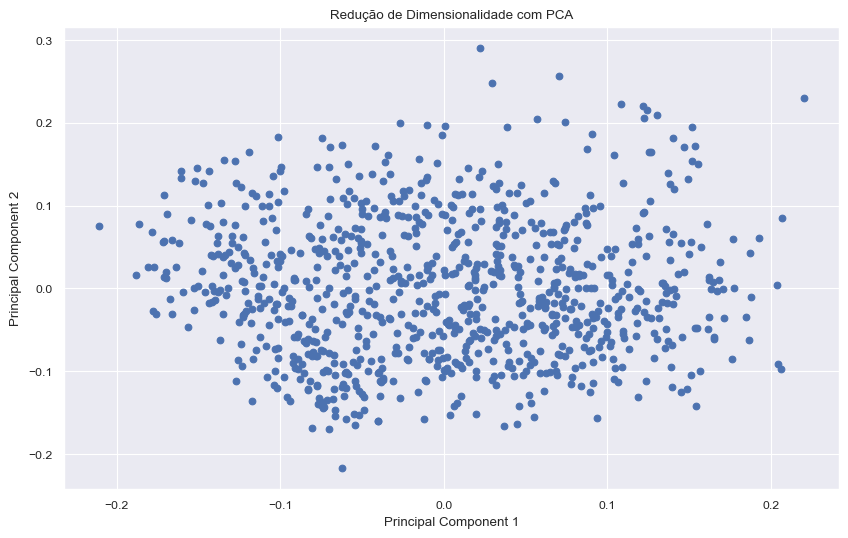

In [9]:
# Definir o número de componentes
n_components = 2  # Você pode ajustar esse valor conforme necessário

# Aplicar PCA
pca = PCA(n_components=n_components)
reduced_matrix_pca = pca.fit_transform(tfidf_matrix.toarray())

# Criar um DataFrame para a matriz reduzida
reduced_df_pca = pd.DataFrame(reduced_matrix_pca, columns=[f'Principal Component {i+1}' for i in range(n_components)])

# Visualizar os dados reduzidos (opcional)
plt.scatter(reduced_df_pca['Principal Component 1'], reduced_df_pca['Principal Component 2'])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Redução de Dimensionalidade com PCA')
plt.show()


## Optimization of number of topics with Perplexity and Coherence

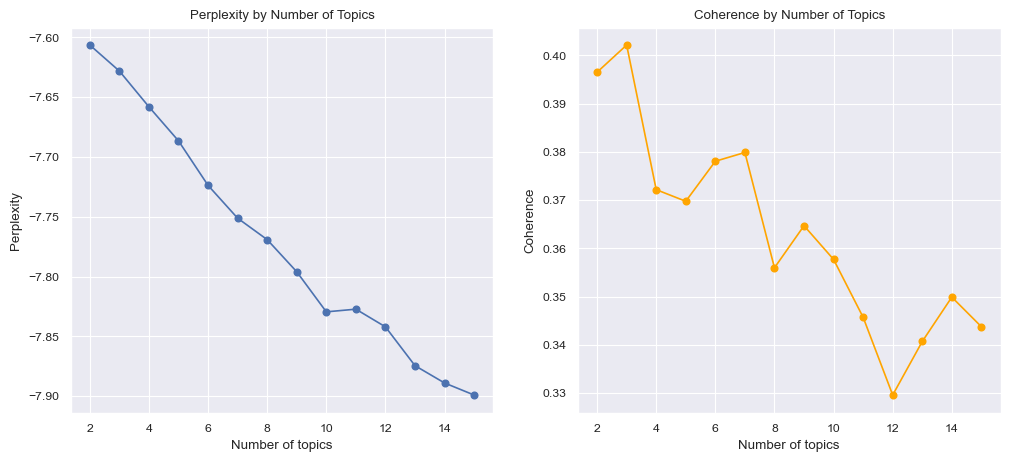

In [10]:
from gensim.models import CoherenceModel

# Load lemmatized abstracts
abstracts_l = abstracts_lemmatize 

# Prepare data
texts = [abstract.split() for abstract in abstracts_l]
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

perplexities = []
coherences = []
num_topics_range = range(2, 16)  # Test 2 to 15 topics

for num_topics in num_topics_range:
    lda_model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=20, random_state=42)
    
    perplexity = lda_model.log_perplexity(corpus)
    perplexities.append(perplexity)
    
    coherence_model = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    coherences.append(coherence_score)

# Results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(num_topics_range, perplexities, marker='o')
plt.title('Perplexity by Number of Topics')
plt.xlabel('Number of topics')
plt.ylabel('Perplexity')

plt.subplot(1, 2, 2)
plt.plot(num_topics_range, coherences, marker='o', color='orange')
plt.title('Coherence by Number of Topics')
plt.xlabel('Number of topics')
plt.ylabel('Coherence')

plt.tight_layout
plt.show()

## Performing LDA for the optimal number of topics

In [ ]:
# Apply LDA
num_topics = 3 #the number of topics is chosen based on the coherence score (higher coherence combined with a lowering perplexity)
lda_model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=40, random_state=42)
generated_topics =[]

# Print topics
topics = lda_model.print_topics(num_words=10)
for topic in topics:
    print(topic)
    generated_topics.append(topic)

# Show visualization
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)

pyLDAvis.display(vis)

(0, '0.009*"portfolio" + 0.008*"optimization" + 0.007*"problem" + 0.007*"propose" + 0.006*"learn" + 0.006*"model" + 0.005*"use" + 0.005*"base" + 0.005*"algorithm" + 0.005*"approach"')
(1, '0.006*"portfolio" + 0.006*"management" + 0.006*"learn" + 0.005*"use" + 0.005*"research" + 0.004*"study" + 0.004*"approach" + 0.004*"base" + 0.003*"process" + 0.003*"provide"')
(2, '0.009*"model" + 0.009*"learn" + 0.008*"return" + 0.007*"market" + 0.007*"use" + 0.007*"asset" + 0.007*"portfolio" + 0.006*"stock" + 0.006*"risk" + 0.006*"base"')


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


In [12]:
display(generated_topics)

[(0,
  '0.009*"portfolio" + 0.008*"optimization" + 0.007*"problem" + 0.007*"propose" + 0.006*"learn" + 0.006*"model" + 0.005*"use" + 0.005*"base" + 0.005*"algorithm" + 0.005*"approach"'),
 (1,
  '0.006*"portfolio" + 0.006*"management" + 0.006*"learn" + 0.005*"use" + 0.005*"research" + 0.004*"study" + 0.004*"approach" + 0.004*"base" + 0.003*"process" + 0.003*"provide"'),
 (2,
  '0.009*"model" + 0.009*"learn" + 0.008*"return" + 0.007*"market" + 0.007*"use" + 0.007*"asset" + 0.007*"portfolio" + 0.006*"stock" + 0.006*"risk" + 0.006*"base"')]

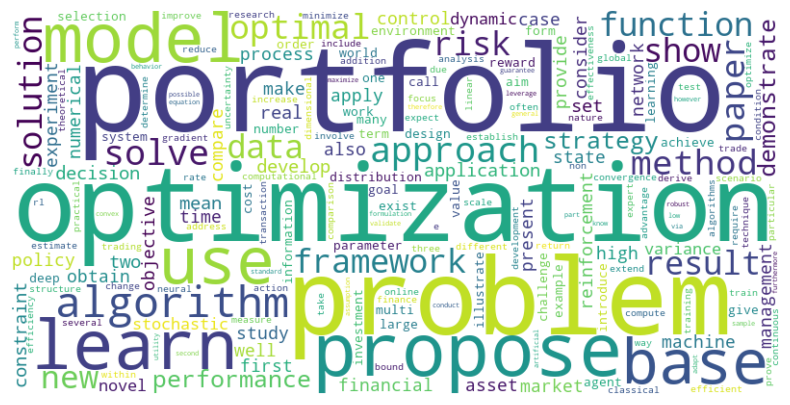

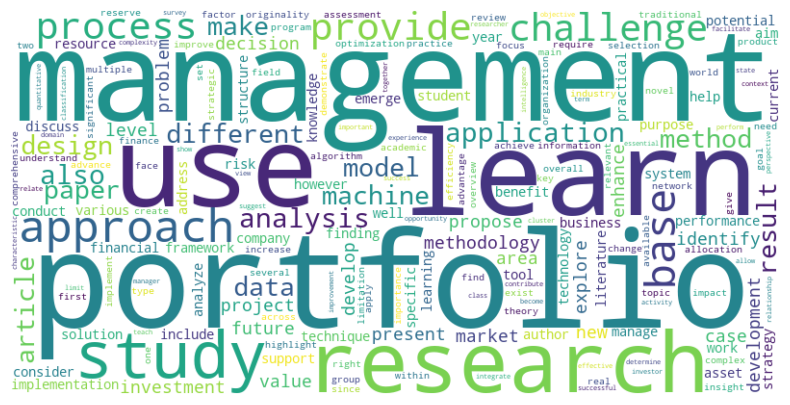

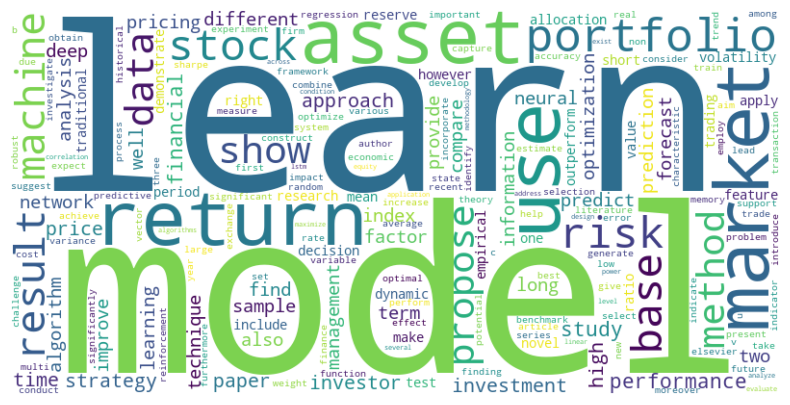

In [13]:
from wordcloud import WordCloud

# Função para gerar a nuvem de palavras para cada tópico
def plot_word_cloud(lda_model, num_topics, num_words=200):
    for topic_id in range(num_topics):
        # Obtém as palavras e suas probabilidades para o tópico
        words_probs = lda_model.show_topic(topic_id, num_words)
        # Constrói uma string para a nuvem de palavras
        word_freq = {word: prob for word, prob in words_probs}
        # Gera a nuvem de palavras
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)
        
        # Plota a nuvem de palavras
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        # plt.title(f'Topic {topic_id}')
        plt.show()

# Chamando a função para exibir as nuvens de palavras de cada tópico
plot_word_cloud(lda_model, num_topics)

In [14]:
# Calculate document-topic probabilities using Gensim
doc_topic_probs = []

for doc_id, doc_bow in enumerate(corpus):
    # Get the topic distribution for the document
    doc_topics = lda_model.get_document_topics(doc_bow, minimum_probability=0)
    # Sort the topics by topic ID
    doc_topics = sorted(doc_topics, key=lambda x: x[0])
    # Extract probabilities
    topic_probs = [prob for topic_id, prob in doc_topics]
    doc_topic_probs.append(topic_probs)

    # Print the probabilities for each document
    # print(f"\nDocument {doc_id}:")
    # for topic_id, prob in doc_topics:
    #     print(f"  Topic {topic_id}: {prob:.4f}")

# Convert the list of probabilities to a DataFrame
import pandas as pd

doc_topic_df = pd.DataFrame(doc_topic_probs)
doc_topic_df.columns = [f"Topic {i}" for i in range(num_topics)]
doc_topic_df.index = [f"Doc {i}" for i in range(len(doc_topic_df))]

# Display the first few rows of the DataFrame
print("\nDocument-Topic Probabilities:")
display(doc_topic_df)

# doc_topic_df.to_csv('doc_topic_probs.csv', index=False)



Document-Topic Probabilities:


,Topic 0,Topic 1,Topic 2
Doc 0,0.004892,0.696820,0.298288
Doc 1,0.002490,0.852368,0.145142
Doc 2,0.335019,0.298906,0.366075
Doc 3,0.007332,0.984913,0.007755
Doc 4,0.004808,0.113098,0.882094
...,...,...,...
Doc 896,0.004126,0.991437,0.004438
Doc 897,0.032217,0.009575,0.958208
Doc 898,0.003437,0.319075,0.677488
Doc 899,0.992665,0.003483,0.003852


In [15]:
# Calculate document-topic probabilities using Gensim
doc_topic_probs = []

for doc_id, doc_bow in enumerate(corpus):
    # Get the topic distribution for the document
    doc_topics = lda_model.get_document_topics(doc_bow, minimum_probability=0)
    # Sort the topics by topic ID
    doc_topics = sorted(doc_topics, key=lambda x: x[0])
    # Extract probabilities
    topic_probs = [prob for topic_id, prob in doc_topics]
    doc_topic_probs.append(topic_probs)

# Conversão da lista de probabilidades em um DataFrame
doc_topic_df = pd.DataFrame(doc_topic_probs)
doc_topic_df.columns = [f"Topic {i}" for i in range(num_topics)]

# Extração de informações adicionais dos documentos
# doc_ids = [getattr(doc, 'id', None) for doc in docs]
doc_titles = [getattr(doc, 'title', '') for doc in docs_orig]
doc_abstracts = [getattr(doc, 'abstract', '') for doc in docs_orig]
doc_authors = [[getattr(author, 'name', '') for author in getattr(doc, 'authors', [])] for doc in docs_orig]
doc_citcount = [getattr(doc, 'citation_count', '') for doc in docs_orig]
doc_year = [getattr(doc, 'publication_year', '') for doc in docs_orig]

# Adição das informações ao DataFrame
# doc_topic_df['ID'] = doc_ids
doc_topic_df['Title'] = doc_titles
doc_topic_df['Abstract'] = doc_abstracts
doc_topic_df['Authors'] = doc_authors
doc_topic_df['Citation Count'] = doc_citcount
doc_topic_df['Year'] = doc_year

# Reorganização das colunas para melhor visualização
cols = ['Title', 'Abstract', 'Authors', 'Citation Count', 'Year'] + [f"Topic {i}" for i in range(num_topics)]
doc_topic_df = doc_topic_df[cols]

# Filtro dos tópicos
topic0 = doc_topic_df[doc_topic_df['Topic 0'] >= 0.7]
citcount = topic0[topic0['Citation Count'] >= 10].sort_values(by='Citation Count', ascending=False)

display(len(citcount))
display(citcount)
citcount.to_clipboard()
# citcount.to_csv('citcount_topic0.csv', sep=";",index=False)

30

,Title,Abstract,Authors,Citation Count,Year,Topic 0,Topic 1,Topic 2
772,"Smart ""Predict, then Optimize""",Many real-world analytics problems involve two...,"[Elmachtoub, A.N., Grigas, P.]",248,2022,0.853515,0.003905,0.142579
522,Machine Learning Approximation Algorithms for ...,High-dimensional partial differential equation...,"[Beck, C., Weinan, E., Jentzen, A.]",175,2019,0.952955,0.003564,0.043482
246,Deep hedging,We present a framework for hedging a portfolio...,"[Buehler, H., Gonon, L., Teichmann, J., Wood, B.]",160,2019,0.986140,0.004304,0.009556
557,Minimax and Biobjective Portfolio Selection Ba...,Portfolio selection is one of the important is...,"[Leung, M.F., Wang, J.]",93,2021,0.722508,0.006829,0.270663
388,Fuzzy portfolio selection based on three-way d...,The goal of fuzzy portfolio selection is to ma...,"[Wang, X.H., Wang, B., Liu, S., Li, H.X., Wang...",82,2022,0.795602,0.004962,0.199436
120,Applications of artificial intelligence in bus...,"In the e-commerce and financial industries, AI...","[Pallathadka H., Ramirez-Asis E.H., Loli-Poma ...",79,2023,0.989711,0.005174,0.005116
430,"IMPACT OF MACHINE learning ON Management, heal...","In the agriculture and healthcare industries, ...","[Pallathadka H., Mustafa M., Sanchez D.T., Sek...",78,2023,0.990841,0.004488,0.004671
115,A parallel variable neighborhood search algori...,"Over the years, portfolio optimization remains...","[Akbay M.A., Kalayci C.B., Polat O.]",58,2020,0.761626,0.003646,0.234728
669,Portfolio optimization of energy communities t...,"Cities are expected to grow further, and energ...","[Fleischhacker, A., Lettner, G., Schwabeneder,...",56,2019,0.833814,0.004971,0.161215
60,A Modern Approach towards an Industry 4.0 Mode...,"Every so often, a confluence of novel technolo...","[Tsaramirsis, G., Kantaros, A., Al-Darraji, I....",55,2022,0.991584,0.004400,0.004016


In [16]:
topic0 = doc_topic_df[doc_topic_df['Topic 0'] >= 0.7]
citcount0 = topic0[topic0['Citation Count'] >= 10].sort_values(by='Citation Count', ascending=False)

display(len(citcount0))
display(citcount0)
citcount0.to_clipboard()

30

,Title,Abstract,Authors,Citation Count,Year,Topic 0,Topic 1,Topic 2
772,"Smart ""Predict, then Optimize""",Many real-world analytics problems involve two...,"[Elmachtoub, A.N., Grigas, P.]",248,2022,0.853515,0.003905,0.142579
522,Machine Learning Approximation Algorithms for ...,High-dimensional partial differential equation...,"[Beck, C., Weinan, E., Jentzen, A.]",175,2019,0.952955,0.003564,0.043482
246,Deep hedging,We present a framework for hedging a portfolio...,"[Buehler, H., Gonon, L., Teichmann, J., Wood, B.]",160,2019,0.986140,0.004304,0.009556
557,Minimax and Biobjective Portfolio Selection Ba...,Portfolio selection is one of the important is...,"[Leung, M.F., Wang, J.]",93,2021,0.722508,0.006829,0.270663
388,Fuzzy portfolio selection based on three-way d...,The goal of fuzzy portfolio selection is to ma...,"[Wang, X.H., Wang, B., Liu, S., Li, H.X., Wang...",82,2022,0.795602,0.004962,0.199436
120,Applications of artificial intelligence in bus...,"In the e-commerce and financial industries, AI...","[Pallathadka H., Ramirez-Asis E.H., Loli-Poma ...",79,2023,0.989711,0.005174,0.005116
430,"IMPACT OF MACHINE learning ON Management, heal...","In the agriculture and healthcare industries, ...","[Pallathadka H., Mustafa M., Sanchez D.T., Sek...",78,2023,0.990841,0.004488,0.004671
115,A parallel variable neighborhood search algori...,"Over the years, portfolio optimization remains...","[Akbay M.A., Kalayci C.B., Polat O.]",58,2020,0.761626,0.003646,0.234728
669,Portfolio optimization of energy communities t...,"Cities are expected to grow further, and energ...","[Fleischhacker, A., Lettner, G., Schwabeneder,...",56,2019,0.833814,0.004971,0.161215
60,A Modern Approach towards an Industry 4.0 Mode...,"Every so often, a confluence of novel technolo...","[Tsaramirsis, G., Kantaros, A., Al-Darraji, I....",55,2022,0.991584,0.004400,0.004016


In [17]:
topic1 = doc_topic_df[doc_topic_df['Topic 1'] >= 0.7]
citcount1 = topic1[topic1['Citation Count'] >= 10].sort_values(by='Citation Count', ascending=False)

display(len(citcount1))
display(citcount1)
citcount1.to_clipboard()

15

,Title,Abstract,Authors,Citation Count,Year,Topic 0,Topic 1,Topic 2
132,Artificial intelligence and machine learning i...,This study reviewed the artificial intelligenc...,"[Ahmed S., Alshater M.M., Ammari A.E., Hammami...",130,2022,0.004390,0.714997,0.280612
705,Project Lineage Management and Project Portfol...,Project portfolio approaches consider various ...,"[Kock A., Gemunden H.G.]",44,2019,0.006464,0.986895,0.006640
362,Finding true north: Design and implementation ...,This study investigates the evolution of the d...,"[Formentini, M., Ellram, L.M., Boem, M., Da Re...",27,2019,0.003827,0.992449,0.003724
707,Project Portfolio Management teaching: Contrib...,Project Portfolio Management (PPM) is becoming...,"[Barbosa, M.W., Rodrigues, C.D.]",27,2020,0.004848,0.990296,0.004856
121,Applications of Explainable Artificial Intelli...,Digitalization and technologization affect num...,"[Weber, P., Carl, K.V., Hinz, O.]",24,2024,0.004425,0.952502,0.043072
46,AI and Machine Learning in Real Estate Investment,The topic of artificial intelligence (AI) is s...,"[Viriato, J.C.]",20,2019,0.004873,0.989809,0.005318
577,Multi-project management in inter-organization...,Multi-project management is typically consider...,"[Martinsuo, M., Ahola, T.]",20,2022,0.005825,0.988367,0.005808
337,Evolution of research in finance over the last...,A standard literature review focuses on the hi...,"[Alhenawi, Y., Hassan, M.K., Hasan, R.]",16,2022,0.003430,0.981295,0.015275
142,Assessment of stored red blood cells through l...,Transfusion of red blood cells (RBCs) is one o...,"[Isiksacan, Z., D'Alessandro, A., Wolf, S.M., ...",15,2023,0.004648,0.990127,0.005225
762,Shaping the event portfolio management field: ...,Purpose - This paper aims to examine how vario...,"[Ziakas, V., Getz, D.]",15,2020,0.003185,0.993511,0.003304


In [18]:
topic2 = doc_topic_df[doc_topic_df['Topic 2'] >= 0.8]
citcount2 = topic2[topic2['Citation Count'] >= 15].sort_values(by='Citation Count', ascending=False)

display(len(citcount2))
display(citcount2)
citcount2.to_clipboard()

73

,Title,Abstract,Authors,Citation Count,Year,Topic 0,Topic 1,Topic 2
313,Empirical Asset Pricing via Machine Learning,We perform a comparative analysis of machine l...,"[Gu, S.H., Kelly, B., Xiu, D.C.]",715,2020,0.007622,0.007228,0.985150
533,Machine learning in the Chinese stock market,We add to the emerging literature on empirical...,"[Leippold, M., Wang, Q., Zhou, W.Y.]",158,2022,0.005446,0.005772,0.988782
550,Mean-variance portfolio optimization using mac...,The success of portfolio construction depends ...,"[Chen, W., Zhang, H.Y., Mehlawat, M.K., Jia, L...",144,2021,0.004319,0.004157,0.991524
237,Decision-making for financial trading: A fusio...,Forecasting stock returns is an exacting prosp...,"[Paiva, F.D., Cardoso, R.T.N., Hanaoka, G.P., ...",139,2019,0.034114,0.127269,0.838617
170,Autoencoder asset pricing models,We propose a new latent factor conditional ass...,"[Gu, S.H., Kelly, B., Xiu, D.C.]",131,2021,0.005581,0.005500,0.988919
...,...,...,...,...,...,...,...,...
108,A novel prediction based portfolio optimizatio...,Portfolio optimization is an important part of...,"[Ma, Y.L., Wang, W.Z., Ma, Q.T.]",16,2023,0.004886,0.004501,0.990613
546,Markowitz Mean-Variance Portfolio Optimization...,"With the advances in time-series prediction, s...","[Chaweewanchon, A., Chaysiri, R.]",16,2022,0.004300,0.004107,0.991593
586,Neural network embeddings on corporate annual ...,"In recent years, there has been an increased i...","[Adosoglou, G., Lombardo, G., Pardalos, P.M.]",15,2021,0.003075,0.003184,0.993741
497,Learning from the Joneses: Technology spillove...,This paper provides empirical evidence for the...,"[Tseng, K.]",15,2022,0.004269,0.004559,0.991173


<Axes: title={'center': 'Year of publications'}, ylabel='No. of documents'>

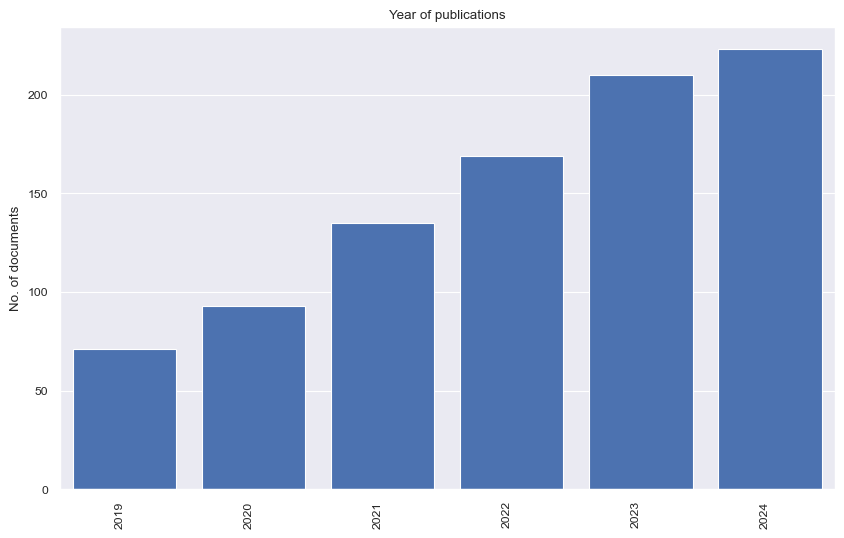

In [19]:
litstudy.plot_year_histogram(docs_orig, vertical=True)